/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


step 1: elapsed 0.8121182918548584
step 2: elapsed 0.009523391723632812
step 3: elapsed 0.011872529983520508
step 4: elapsed 0.30641722679138184
step 5: elapsed 0.001975536346435547
step 5: elapsed 0.0023500919342041016
elapsed 1.14552640914917


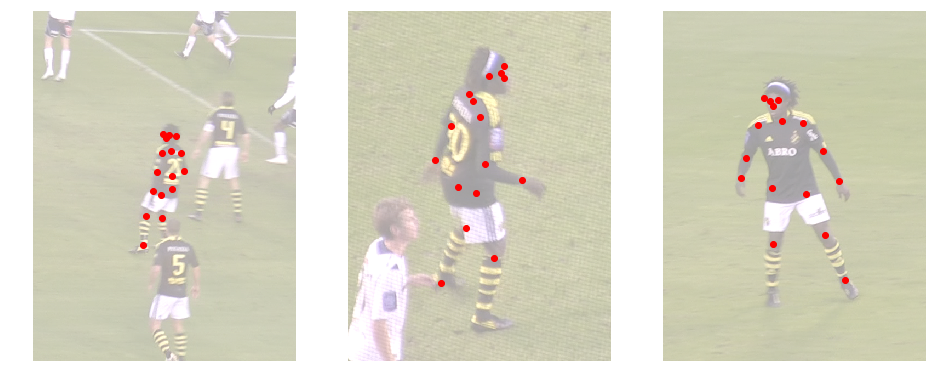

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')

import numpy as np
import mvpose.data.kth_football2 as kth
from mvpose import pose
import paf_loader
from time import time

from mvpose.algorithm import settings
import mvpose.data.skeleton_augmentation as ska
from mvpose.algorithm.candidate_selection import project_human_to_2d

params = settings.get_settings(scale_to_mm=1000)

FRAME = 10
data_root = Settings['data_root']
seq1_zipname = 'player1sequence2.zip'
seq1_dir = 'Sequence 2'
Im, Calib, pos2d, pos3d = kth.get(data_root, seq1_zipname, seq1_dir, FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME)
_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs,
                                  settings=params, debug=True)
_end = time()
print('elapsed', _end - _start)

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[pid])
    
plt.show()

norm. human:		 (13, 4)
norm. human (rs):	 (1, 52)
ypred:			 (13, 3)
prediction time: 0.25136446952819824


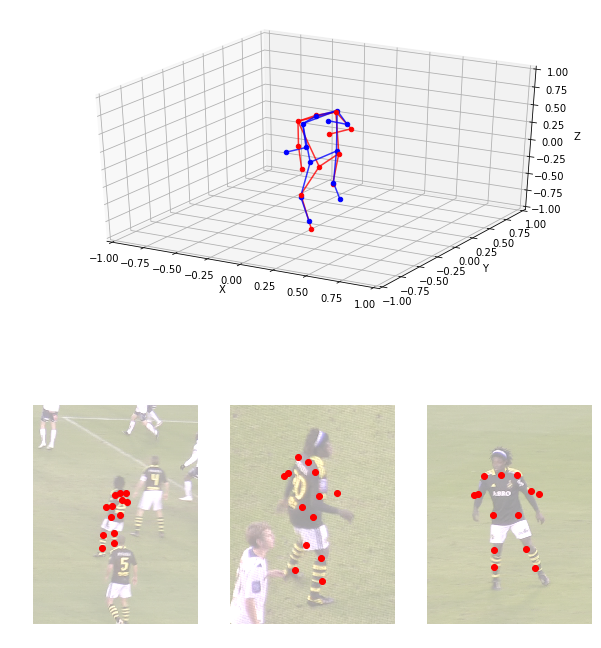

In [36]:
from keras.models import load_model

model = load_model('../data/model_poseprediction.h5')

humans = np.squeeze(ska.transform_from_mscoco(Humans))
normalized_human = ska.normalize(humans, params)
print('norm. human:\t\t', normalized_human.shape)
normalized_human_rs = normalized_human.reshape(1, 13*4)
print('norm. human (rs):\t', normalized_human_rs.shape)

_start = time()
y_pred = np.squeeze(model.predict(normalized_human_rs).reshape(1, 13, 3))
_end = time()
print('ypred:\t\t\t', y_pred.shape)
print('prediction time:', _end - _start)


fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(211, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')

ska.plot_indv(ax, normalized_human[:,0:3], normalized_human[:,3])
ska.plot_indv(ax, y_pred, color='blue')


denormalized = ska.denormalize(y_pred, params)

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,3,4+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    pts2d = cam.projectPoints(denormalized)
    
    for x,y in pts2d:
        ax.scatter(x,y, color='red')
    
    
    
plt.show()